<a href="https://colab.research.google.com/github/guangyitan/ImageProcessing-FaceMaskClassification/blob/main/Train_DenseNet169.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm

from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
project_path = '/content/MyDrive/My Drive/Colab Notebooks/Image Processing/Face Mask Detection Assignment/'
model_path = '/content/MyDrive/My Drive/Colab Notebooks/Image Processing/Face Mask Detection Assignment/Trained_Models/DenseNet169/'
dataset_path = project_path + 'Balanced_Dataset'

print(dataset_path)

/content/MyDrive/My Drive/Colab Notebooks/Image Processing/Face Mask Detection Assignment/Balanced_Dataset


In [ ]:
# Initialize the path for dataset
imagePaths=list(paths.list_images(dataset_path))
print("Number of dataset:", len(imagePaths))

Number of dataset: 2500


In [ ]:
imagePaths[0].split(os.path.sep)[-2]


'Mask_Nose_Mouth'

# Load and preprocess dataset

In [ ]:
# initialize dataset and its label
data=[]
labels=[]

for i in tqdm(imagePaths):

  # get the dataset label from its path
  label = i.split(os.path.sep)[-2]
  labels.append(label)

  # get the dataset image, convert to array and preprocess it
  image = load_img(i, target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)
  data.append(image)

100%|██████████| 2500/2500 [22:17<00:00,  1.87it/s]


In [ ]:
# convert data and label to np array
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# labels = to_categorical(labels)

# split the data into 70% for training and 30% for testing 
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.30, stratify=labels, random_state=10)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
# check the shape of splited dataset
print("trainX:", trainX.shape)
print("testX:", testX.shape)
print("trainY:", trainY.shape)
print("testY:", testY.shape)

trainX: (1750, 224, 224, 3)
testX: (750, 224, 224, 3)
trainY: (1750, 5)
testY: (750, 5)


# Start Constructing the Model 

In [ ]:
# load the DenseNet169 network, ensuring the head FC layer sets are left off
baseModel = DenseNet169(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the base model
# I'm using softmax for multiclass classification 
# the output of model has 3 classes (mask, no_mask, wrong_mask)
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(5, activation="softmax")(headModel)

# place the head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and set them as not trainable
for layer in baseModel.layers:
	layer.trainable = False

# check the architecture of the model
# Total params: 2,422,339
# Trainable params: 164,355 (from the layers that was added to the MobileNetV2)
# Non-trainable params: 2,257,984
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

# Training the Model

In [ ]:
# initialize the learning rate, epochs and batch size to train the model
learning_rate = 0.001
epochs = 20
bs = 32

# initialize the optimizer 
optimizer = Adam(learning_rate = learning_rate, decay=learning_rate/epochs)

# complie the model
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

# start training the model
hist = model.fit(
    aug.flow(trainX, trainY, batch_size = bs),
    steps_per_epoch = len(trainX)//bs,
    validation_data = (testX, testY),
    validation_steps = len(testX)//bs,
    epochs = epochs
)

Epoch 1/20
54/54 [==============================] - 50s 748ms/step - loss: 0.9525 - accuracy: 0.6135 - val_loss: 0.2906 - val_accuracy: 0.9307
Epoch 2/20
54/54 [==============================] - 30s 564ms/step - loss: 0.3794 - accuracy: 0.8632 - val_loss: 0.1958 - val_accuracy: 0.9453
Epoch 3/20
54/54 [==============================] - 30s 562ms/step - loss: 0.3247 - accuracy: 0.8807 - val_loss: 0.1557 - val_accuracy: 0.9573
Epoch 4/20
54/54 [==============================] - 30s 561ms/step - loss: 0.2511 - accuracy: 0.9162 - val_loss: 0.1302 - val_accuracy: 0.9587
Epoch 5/20
54/54 [==============================] - 35s 644ms/step - loss: 0.2217 - accuracy: 0.9284 - val_loss: 0.1104 - val_accuracy: 0.9640
Epoch 6/20
54/54 [==============================] - 31s 564ms/step - loss: 0.2128 - accuracy: 0.9278 - val_loss: 0.1052 - val_accuracy: 0.9653
Epoch 7/20
54/54 [==============================] - 31s 566ms/step - loss: 0.1931 - accuracy: 0.9261 - val_loss: 0.1022 - val_accuracy: 0.9720

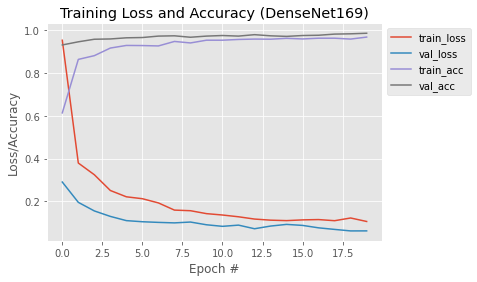

In [ ]:
# plot the training loss and accuracy graph
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (DenseNet169)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(bbox_to_anchor=(1, 1))

In [ ]:
# Test the model using testing dataset
predict = model.predict(testX, batch_size = bs)

predict = np.argmax(predict,axis=1)
print(classification_report(testY.argmax(axis=1), predict, target_names=lb.classes_))

                 precision    recall  f1-score   support

   Correct_Mask       0.99      0.99      0.99       150
      Mask_Chin       0.97      0.98      0.98       150
Mask_Mouth_Chin       0.99      0.97      0.98       150
Mask_Nose_Mouth       0.99      0.99      0.99       150
        No_Mask       0.99      0.99      0.99       150

       accuracy                           0.99       750
      macro avg       0.99      0.99      0.99       750
   weighted avg       0.99      0.99      0.99       750



# Save model, weights, training history

In [ ]:
save_model_path = model_path + "Saved_Model"
save_weights_path = model_path +"Saved_Weights"

#Save the trained model
model.save(save_model_path) 

# Save the weights
model.save_weights(save_weights_path)

INFO:tensorflow:Assets written to: /content/MyDrive/My Drive/Colab Notebooks/Image Processing/Face Mask Detection Assignment/Trained_Models/DenseNet169/Saved_Model/assets


In [ ]:
import pickle 
with open(model_path + 'hist.txt', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(hist, filehandle)

INFO:tensorflow:Assets written to: ram://c5217505-ee00-4db5-a8a5-f74aa85f0e92/assets


# Load Model and History

In [ ]:
# # To load the model
new_model = load_model('/content/MyDrive/My Drive/Colab Notebooks/Image Processing/Face Mask Detection Assignment/Trained_Models/DenseNet169/Saved_model')

In [ ]:
# load model history
import pickle

with open('/content/MyDrive/My Drive/Colab Notebooks/Image Processing/Face Mask Detection Assignment/Trained_Models/DenseNet169/hist.txt', 'rb') as filehandle:
    # read the data as binary data stream
    hist = pickle.load(filehandle)

In [ ]:
# function ClickConnect(){
#     console.log("Clicked on connect button"); 
#     document.querySelector("colab-connect-button").click()
# }
# setInterval(ClickConnect,60000)